In [ ]:
# ---------------------------
# 0) Install (Colab) - run once
# ---------------------------
!pip install -q torch torchvision --quiet
!pip install -q opencv-python scikit-learn matplotlib tqdm

In [ ]:
# ---------------------------
# 1) Imports & Config
# ---------------------------
import os, glob, json, math, time
from pathlib import Path
from typing import List, Tuple, Dict
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
!rm -rf /content/drive
!mkdir /content/drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 📌 Step C: Find All Paired Files

import glob
import os
from sklearn.model_selection import train_test_split

data_dir = "/content/drive/MyDrive/AI Y4S1/output_scene_dataset_3"

depth_files = sorted(glob.glob(os.path.join(data_dir, "*dented_depth.npy")))
mask_files = sorted(glob.glob(os.path.join(data_dir, "*dent_mask.png")))

items = list(zip(depth_files, mask_files))
print("Total paired samples:", len(items))

# ---------------------------
# 2) Paths (EDIT if needed)
# ---------------------------
DATA_DIR = data_dir  # <-- set to your folder
OUT_DIR = os.path.join(data_dir, "predictions")
os.makedirs(OUT_DIR, exist_ok=True)


Total paired samples: 1209


In [ ]:
# ---------------------------
# 3) Dataset
# ---------------------------
class DepthDentDataset(Dataset):
    """
    Input: depth .npy (H,W)
           mask .png (H,W) or .npy (H,W) (binary 0/255 or 0/1)
    Output: tensor input (C,H,W) where C=3 -> [depth_norm, gx_norm, gy_norm]
            mask tensor (1,H,W) float32 0/1
    """
    def __init__(self, samples: List[Tuple[str,str]], augment: bool=False):
        self.samples = samples
        self.augment = augment

    def __len__(self):
        return len(self.samples)

    def _load_depth(self, path):
        d = np.load(path).astype(np.float32)
        return d

    def _load_mask(self, path):
        p = Path(path)
        if p.suffix.lower() == ".npy":
            m = np.load(path)
            m = (m > 0).astype(np.uint8)
        else:
            m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if m is None:
                raise RuntimeError(f"Cannot read mask: {path}")
            m = (m > 127).astype(np.uint8)
        return m

    def _normalize(self, depth):
        valid = np.isfinite(depth) & (depth > 0)
        if not np.any(valid):
            return np.zeros_like(depth, dtype=np.float32)
        d = depth.copy()
        d_min = float(np.min(d[valid]))
        d_max = float(np.max(d[valid]))
        if d_max - d_min < 1e-6:
            return np.zeros_like(d, dtype=np.float32)
        norm = (d - d_min) / (d_max - d_min)
        norm[~valid] = 0.0
        return norm.astype(np.float32)

    def _gradients(self, depth):
        gx = cv2.Sobel(depth, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(depth, cv2.CV_32F, 0, 1, ksize=3)
        # robust normalization
        def robust_norm(x):
            v = x.flatten()
            v = v[np.isfinite(v)]
            if v.size == 0:
                return np.zeros_like(x, dtype=np.float32)
            med = np.median(v)
            mad = np.median(np.abs(v - med)) + 1e-6
            out = (x - med) / (3.0 * mad)
            out = np.clip(out, -3.0, 3.0)
            out = (out - out.min()) / (out.max() - out.min() + 1e-9)
            return out.astype(np.float32)
        return robust_norm(gx), robust_norm(gy)

    def __getitem__(self, idx):
        depth_path, mask_path = self.samples[idx]
        depth = self._load_depth(depth_path)          # shape (H,W) float32
        mask = self._load_mask(mask_path)             # uint8 0/1

        # compute features
        depth_n = self._normalize(depth)
        gx, gy = self._gradients(depth)

        # stack -> (C,H,W)
        inp = np.stack([depth_n, gx, gy], axis=0).astype(np.float32)

        # augment simple flips
        if self.augment:
            if np.random.rand() < 0.5:
                inp = inp[:, :, ::-1]   # hflip
                mask = mask[:, ::-1]
            if np.random.rand() < 0.5:
                inp = inp[:, ::-1, :]   # vflip
                mask = mask[::-1, :]

        mask = (mask > 0).astype(np.float32)[None, ...]   # (1,H,W)
        return torch.from_numpy(inp.copy()), torch.from_numpy(mask.copy())


In [ ]:
# ---------------------------
# 4) Model: Attention-UNet
# ---------------------------
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=3, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel, padding=padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(nn.Conv2d(F_g, F_int, kernel_size=1), nn.BatchNorm2d(F_int))
        self.W_x = nn.Sequential(nn.Conv2d(F_l, F_int, kernel_size=1), nn.BatchNorm2d(F_int))
        self.psi = nn.Sequential(nn.ReLU(inplace=True),
                                 nn.Conv2d(F_int, 1, kernel_size=1),
                                 nn.Sigmoid())

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)

        # Upsample gating signal to match x1 size if needed
        if g1.shape[2:] != x1.shape[2:]:
            g1 = F.interpolate(g1, size=x1.shape[2:], mode='bilinear', align_corners=True)

        psi = self.psi(g1 + x1)
        return x * psi

class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_ch, out_ch)
    def forward(self, x, skip):
        x = self.up(x)
        if x.size() != skip.size():
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        return self.conv(torch.cat([x, skip], dim=1))

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, filters=[32,64,128,256]):
        super().__init__()
        f1, f2, f3, f4 = filters
        self.enc1 = ConvBlock(in_channels, f1)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ConvBlock(f1, f2)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(f2, f3)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ConvBlock(f3, f4)
        self.pool4 = nn.MaxPool2d(2)
        self.center = ConvBlock(f4, f4*2)

        self.att4 = AttentionGate(F_g=f4*2, F_l=f4, F_int=f4)
        self.dec4 = UpBlock(f4*2, f4)
        self.att3 = AttentionGate(F_g=f4, F_l=f3, F_int=f3)
        self.dec3 = UpBlock(f4, f3)
        self.att2 = AttentionGate(F_g=f3, F_l=f2, F_int=f2)
        self.dec2 = UpBlock(f3, f2)
        self.att1 = AttentionGate(F_g=f2, F_l=f1, F_int=f1)
        self.dec1 = UpBlock(f2, f1)

        self.final = nn.Conv2d(f1, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        c = self.center(self.pool4(e4))

        g4 = c
        x4 = self.att4(g4, e4)
        d4 = self.dec4(c, x4)

        g3 = d4
        x3 = self.att3(g3, e3)
        d3 = self.dec3(d4, x3)

        g2 = d3
        x2 = self.att2(g2, e2)
        d2 = self.dec2(d3, x2)

        g1 = d2
        x1 = self.att1(g1, e1)
        d1 = self.dec1(d2, x1)

        out = self.final(d1)
        return out

In [ ]:
# ---------------------------
# 5) Losses & Metrics
# ---------------------------
def dice_loss_tensor(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    inter = (pred * target).sum(dim=(1,2,3))
    denom = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = 1 - ((2*inter + smooth) / (denom + smooth))
    return dice.mean()

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, pred, target):
        # pred: logits
        bce_loss = self.bce(pred, target)
        pt = torch.exp(-bce_loss)
        loss = ((1-pt)**self.gamma * bce_loss).mean()
        return loss

def combined_loss(pred, target):
    # 0.5 * Dice + 0.5 * Focal
    return 0.5 * dice_loss_tensor(pred, target) + 0.5 * FocalLoss()(pred, target)

# Metrics
def iou_score_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (torch.sigmoid(pred) > thr).float()
    inter = (pred_bin * target).sum(dim=(1,2,3))
    union = (pred_bin + target - pred_bin*target).sum(dim=(1,2,3))
    return ((inter + eps) / (union + eps)).mean().item()

def dice_score_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (torch.sigmoid(pred) > thr).float()
    inter = (pred_bin * target).sum(dim=(1,2,3))
    denom = (pred_bin + target).sum(dim=(1,2,3))
    return ((2*inter + eps) / (denom + eps)).mean().item()

def precision_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (torch.sigmoid(pred) > thr).float()
    tp = (pred_bin * target).sum(dim=(1,2,3))
    fp = (pred_bin * (1-target)).sum(dim=(1,2,3))
    return ((tp + eps) / (tp + fp + eps)).mean().item()

def recall_batch(pred, target, thr=0.5, eps=1e-6):
    pred_bin = (torch.sigmoid(pred) > thr).float()
    tp = (pred_bin * target).sum(dim=(1,2,3))
    fn = ((1-pred_bin) * target).sum(dim=(1,2,3))
    return ((tp + eps) / (tp + fn + eps)).mean().item()

In [ ]:
# ---------------------------
# 6) Prepare dataset & sampler
# ---------------------------
# Pair depth and mask files
depth_paths = sorted(glob.glob(os.path.join(DATA_DIR, "*dented_depth.npy")))
pairs = []
for dp in depth_paths:
    base = os.path.basename(dp).replace("_dented_depth.npy","")
    mp = os.path.join(DATA_DIR, base + "_dent_mask.png")
    if not os.path.exists(mp):
        mp_alt = os.path.join(DATA_DIR, base + "_dent_mask.npy")
        if os.path.exists(mp_alt):
            mp = mp_alt
        else:
            print("Missing mask for:", dp)
            continue
    pairs.append((dp, mp))

print("Total paired samples:", len(pairs))

# Proper train/val/test split: 70% train, 15% val, 15% test
# First split: separate out test set (15%)
train_val_pairs, test_pairs = train_test_split(pairs, test_size=0.15, random_state=42)
# Second split: split remaining into train (70% of total) and val (15% of total)
# Since we have 85% left, we need 70/85 = 0.8235 to get 70% of original
train_pairs, val_pairs = train_test_split(train_val_pairs, test_size=0.1765, random_state=42)

print(f"Train samples: {len(train_pairs)} ({100*len(train_pairs)/len(pairs):.1f}%)")
print(f"Val samples: {len(val_pairs)} ({100*len(val_pairs)/len(pairs):.1f}%)")
print(f"Test samples: {len(test_pairs)} ({100*len(test_pairs)/len(pairs):.1f}%)")
print("⚠️ Test set is completely separate and will ONLY be used for final evaluation!")

# compute weights for sampler (oversample positive mask images)
def sample_weight(pair):
    _, mask_path = pair
    if mask_path.endswith(".npy"):
        m = np.load(mask_path)
    else:
        m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    has_pos = (m > 0).sum() > 0
    return 1.0 if has_pos else 0.2  # give less weight to no-dent images

weights = [sample_weight(p) for p in train_pairs]
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_ds = DepthDentDataset(train_pairs, augment=True)
val_ds = DepthDentDataset(val_pairs, augment=False)

train_loader = DataLoader(train_ds, batch_size=4, sampler=sampler, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False, num_workers=2)

Total paired samples: 1209
Train samples: 845 (69.9%)
Val samples: 182 (15.1%)
Test samples: 182 (15.1%)
⚠️ Test set is completely separate and will ONLY be used for final evaluation!


In [ ]:
# ---------------------------
# 7) Create model / optimizer
# ---------------------------
model = AttentionUNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3
)

if scheduler.num_bad_epochs == 0:
    print("↘ LR reduced!")



↘ LR reduced!


In [ ]:
# ---------------------------
# 8) Training loop with Early Stopping
# ---------------------------
NUM_EPOCHS = 50  # 50 epochs, but early stopping will prevent overfitting
best_iou = 0.0
save_path = os.path.join(OUT_DIR, "best_attention_unet.pth")

# Early stopping parameters
patience = 7  # Stop if no improvement for 7 epochs
patience_counter = 0
min_delta = 0.001  # Minimum change to qualify as improvement

# Track history for analysis
train_losses = []
val_losses = []
val_ious = []

for epoch in range(1, NUM_EPOCHS+1):
    model.train()
    running_loss = 0.0
    for inp, mask in tqdm(train_loader, desc=f"Epoch {epoch} [train]"):
        inp = inp.to(device)
        mask = mask.to(device)
        optimizer.zero_grad()
        outputs = model(inp)
        loss = combined_loss(outputs, mask)
        loss.backward()
        optimizer.step()
        running_loss += float(loss.item())

    # Validation
    model.eval()
    val_loss = 0.0
    iou_acc = 0.0
    dice_acc = 0.0
    prec_acc = 0.0
    rec_acc = 0.0
    n_batches = 0
    with torch.no_grad():
        for inp, mask in tqdm(val_loader, desc=f"Epoch {epoch} [val]"):
            inp = inp.to(device)
            mask = mask.to(device)
            outputs = model(inp)
            loss = combined_loss(outputs, mask)
            val_loss += float(loss.item())
            iou_acc += iou_score_batch(outputs, mask)
            dice_acc += dice_score_batch(outputs, mask)
            prec_acc += precision_batch(outputs, mask)
            rec_acc += recall_batch(outputs, mask)
            n_batches += 1

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / (n_batches if n_batches>0 else 1)
    avg_iou = iou_acc / (n_batches if n_batches>0 else 1)
    avg_dice = dice_acc / (n_batches if n_batches>0 else 1)
    avg_prec = prec_acc / (n_batches if n_batches>0 else 1)
    avg_rec = rec_acc / (n_batches if n_batches>0 else 1)

    # Track history
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_ious.append(avg_iou)

    # Calculate gap between train and val loss (overfitting indicator)
    loss_gap = avg_train_loss - avg_val_loss

    print(f"Epoch {epoch}/{NUM_EPOCHS} TrainLoss: {avg_train_loss:.4f} ValLoss: {avg_val_loss:.4f} Val IoU: {avg_iou:.4f} Dice: {avg_dice:.4f} Prec: {avg_prec:.4f} Rec: {avg_rec:.4f} Gap: {loss_gap:.4f}")

    # scheduler step on IoU
    scheduler.step(avg_iou)

    # Early stopping check: improve on IoU
    if avg_iou > best_iou + min_delta:
        best_iou = avg_iou
        patience_counter = 0
        torch.save(model.state_dict(), save_path)
        print(f"✓ Saved best model (IoU: {best_iou:.4f}): {save_path}")
    else:
        patience_counter += 1
        print(f"  No improvement ({patience_counter}/{patience} patience)")

        # Check for overfitting warning
        if loss_gap < -0.05:  # Train loss significantly lower than val loss
            print(f"  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)")

    # Early stopping
    if patience_counter >= patience:
        print(f"\n⏹️  Early stopping triggered! No improvement for {patience} epochs.")
        print(f"Best IoU achieved: {best_iou:.4f} at epoch {epoch - patience}")
        break

print(f"\nTraining complete. Best IoU: {best_iou:.4f}")
print(f"Final train/val loss gap: {train_losses[-1] - val_losses[-1]:.4f}")

Epoch 1 [val]: 100%|██████████| 46/46 [00:11<00:00,  4.15it/s]


Epoch 1/50 TrainLoss: 0.3524 ValLoss: 0.5862 IoU: 0.2148 Dice: 0.2931 Prec: 0.2220 Rec: 0.9817 Gap: -0.2338
✓ Saved best model (IoU: 0.2148): /content/drive/MyDrive/AI Y4S1/output_scene_dataset_3/predictions/best_attention_unet.pth


Epoch 2 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.09it/s]


Epoch 2/50 TrainLoss: 0.2556 ValLoss: 0.2844 IoU: 0.7425 Dice: 0.7956 Prec: 0.8560 Rec: 0.8715 Gap: -0.0288
✓ Saved best model (IoU: 0.7425): /content/drive/MyDrive/AI Y4S1/output_scene_dataset_3/predictions/best_attention_unet.pth


Epoch 3 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.57it/s]


Epoch 3/50 TrainLoss: 0.2301 ValLoss: 0.2986 IoU: 0.7149 Dice: 0.7793 Prec: 0.9402 Rec: 0.7576 Gap: -0.0685
  No improvement (1/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 4 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.75it/s]


Epoch 4/50 TrainLoss: 0.2090 ValLoss: 0.2610 IoU: 0.6810 Dice: 0.7388 Prec: 0.7904 Rec: 0.8611 Gap: -0.0520
  No improvement (2/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 5 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.78it/s]


Epoch 5/50 TrainLoss: 0.1881 ValLoss: 0.3028 IoU: 0.5617 Dice: 0.6294 Prec: 0.5879 Rec: 0.9503 Gap: -0.1147
  No improvement (3/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 6 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.72it/s]


Epoch 6/50 TrainLoss: 0.1782 ValLoss: 0.2698 IoU: 0.6099 Dice: 0.6741 Prec: 0.6335 Rec: 0.9574 Gap: -0.0917
  No improvement (4/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 7 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.46it/s]


Epoch 7/50 TrainLoss: 0.1660 ValLoss: 0.2467 IoU: 0.7373 Dice: 0.7868 Prec: 0.8095 Rec: 0.9054 Gap: -0.0807
  No improvement (5/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 8 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.93it/s]


Epoch 8/50 TrainLoss: 0.1689 ValLoss: 0.2371 IoU: 0.7059 Dice: 0.7575 Prec: 0.7378 Rec: 0.9502 Gap: -0.0682
  No improvement (6/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 9 [val]: 100%|██████████| 46/46 [00:08<00:00,  5.68it/s]


Epoch 9/50 TrainLoss: 0.1537 ValLoss: 0.2417 IoU: 0.7447 Dice: 0.7948 Prec: 0.8148 Rec: 0.9103 Gap: -0.0879
✓ Saved best model (IoU: 0.7447): /content/drive/MyDrive/AI Y4S1/output_scene_dataset_3/predictions/best_attention_unet.pth


Epoch 10 [val]: 100%|██████████| 46/46 [00:08<00:00,  5.70it/s]


Epoch 10/50 TrainLoss: 0.1546 ValLoss: 0.2490 IoU: 0.7119 Dice: 0.7597 Prec: 0.7903 Rec: 0.9003 Gap: -0.0944
  No improvement (1/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 11 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.31it/s]


Epoch 11/50 TrainLoss: 0.1567 ValLoss: 0.2583 IoU: 0.7905 Dice: 0.8410 Prec: 0.8944 Rec: 0.8776 Gap: -0.1017
✓ Saved best model (IoU: 0.7905): /content/drive/MyDrive/AI Y4S1/output_scene_dataset_3/predictions/best_attention_unet.pth


Epoch 12 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.71it/s]


Epoch 12/50 TrainLoss: 0.1381 ValLoss: 0.2416 IoU: 0.7369 Dice: 0.7866 Prec: 0.8095 Rec: 0.9036 Gap: -0.1035
  No improvement (1/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 13 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.73it/s]


Epoch 13/50 TrainLoss: 0.1551 ValLoss: 0.2489 IoU: 0.8352 Dice: 0.8847 Prec: 0.9338 Rec: 0.8837 Gap: -0.0938
✓ Saved best model (IoU: 0.8352): /content/drive/MyDrive/AI Y4S1/output_scene_dataset_3/predictions/best_attention_unet.pth


Epoch 14 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.71it/s]


Epoch 14/50 TrainLoss: 0.1367 ValLoss: 0.2433 IoU: 0.7392 Dice: 0.7888 Prec: 0.7755 Rec: 0.9417 Gap: -0.1066
  No improvement (1/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 15 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.53it/s]


Epoch 15/50 TrainLoss: 0.1578 ValLoss: 0.2494 IoU: 0.7639 Dice: 0.8157 Prec: 0.8486 Rec: 0.8993 Gap: -0.0916
  No improvement (2/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 16 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.81it/s]


Epoch 16/50 TrainLoss: 0.1504 ValLoss: 0.2787 IoU: 0.7997 Dice: 0.8586 Prec: 0.9563 Rec: 0.8326 Gap: -0.1283
  No improvement (3/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 17 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.81it/s]


Epoch 17/50 TrainLoss: 0.1550 ValLoss: 0.2317 IoU: 0.8092 Dice: 0.8569 Prec: 0.8654 Rec: 0.9264 Gap: -0.0767
  No improvement (4/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 18 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.19it/s]


Epoch 18/50 TrainLoss: 0.1402 ValLoss: 0.2303 IoU: 0.8291 Dice: 0.8754 Prec: 0.8913 Rec: 0.9194 Gap: -0.0900
  No improvement (5/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 19 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.40it/s]


Epoch 19/50 TrainLoss: 0.1374 ValLoss: 0.2339 IoU: 0.8580 Dice: 0.9033 Prec: 0.9283 Rec: 0.9088 Gap: -0.0965
✓ Saved best model (IoU: 0.8580): /content/drive/MyDrive/AI Y4S1/output_scene_dataset_3/predictions/best_attention_unet.pth


Epoch 20 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.76it/s]


Epoch 20/50 TrainLoss: 0.1451 ValLoss: 0.2325 IoU: 0.8139 Dice: 0.8616 Prec: 0.8671 Rec: 0.9306 Gap: -0.0874
  No improvement (1/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 21 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.75it/s]


Epoch 21/50 TrainLoss: 0.1415 ValLoss: 0.2326 IoU: 0.7912 Dice: 0.8390 Prec: 0.8382 Rec: 0.9377 Gap: -0.0911
  No improvement (2/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 22 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.32it/s]


Epoch 22/50 TrainLoss: 0.1490 ValLoss: 0.2303 IoU: 0.8387 Dice: 0.8836 Prec: 0.8898 Rec: 0.9243 Gap: -0.0814
  No improvement (3/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 23 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.81it/s]


Epoch 23/50 TrainLoss: 0.1399 ValLoss: 0.2413 IoU: 0.8366 Dice: 0.8830 Prec: 0.9224 Rec: 0.8972 Gap: -0.1014
  No improvement (4/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 24 [val]: 100%|██████████| 46/46 [00:07<00:00,  5.79it/s]


Epoch 24/50 TrainLoss: 0.1332 ValLoss: 0.2283 IoU: 0.8519 Dice: 0.8975 Prec: 0.9251 Rec: 0.9121 Gap: -0.0951
  No improvement (5/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 25 [val]: 100%|██████████| 46/46 [00:07<00:00,  6.11it/s]


Epoch 25/50 TrainLoss: 0.1392 ValLoss: 0.2313 IoU: 0.8382 Dice: 0.8843 Prec: 0.9177 Rec: 0.9074 Gap: -0.0921
  No improvement (6/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)


Epoch 26 [val]: 100%|██████████| 46/46 [00:06<00:00,  6.76it/s]

Epoch 26/50 TrainLoss: 0.1276 ValLoss: 0.2288 IoU: 0.8481 Dice: 0.8927 Prec: 0.9080 Rec: 0.9162 Gap: -0.1012
  No improvement (7/7 patience)
  ⚠️ Warning: Possible overfitting (Train loss much lower than Val loss)

⏹️  Early stopping triggered! No improvement for 7 epochs.
Best IoU achieved: 0.8580 at epoch 19

Training complete. Best IoU: 0.8580
Final train/val loss gap: -0.1012


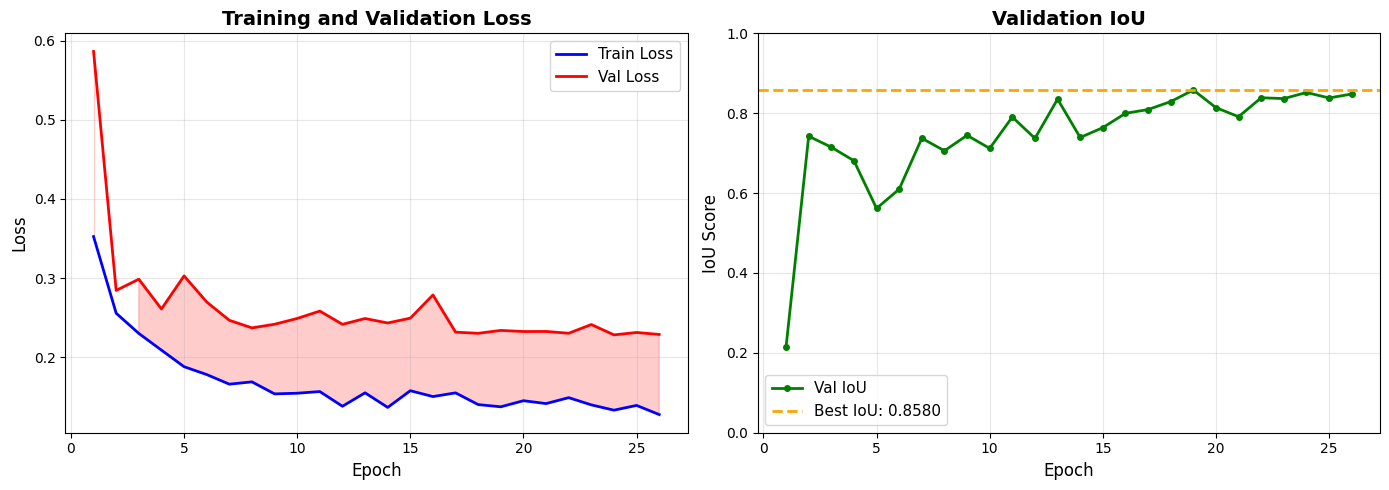


TRAINING ANALYSIS
Best IoU: 0.8580
Final Train Loss: 0.1276
Final Val Loss: 0.2288
Final Loss Gap (Train - Val): -0.1012

⚠️  OVERFITTING DETECTED:
   - Train loss is significantly lower than validation loss
   - Model is memorizing training data rather than generalizing
   - Consider: more regularization, dropout, or data augmentation


In [ ]:
# ---------------------------
# 8.5) Visualize Training Curves - FIXED VERSION (Run after training)
# ---------------------------
# Check if training history exists (from training cell)
try:
    # Check if variables exist in global scope
    if 'train_losses' in globals() and len(train_losses) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        epochs = range(1, len(train_losses) + 1)

        # Plot 1: Loss curves
        axes[0].plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
        axes[0].plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=11)
        axes[0].grid(True, alpha=0.3)

        # Highlight overfitting region (where gap is large)
        if len(train_losses) > 5:
            gap = np.array(train_losses) - np.array(val_losses)
            overfit_mask = gap < -0.05  # Where train loss is much lower than val loss
            if np.any(overfit_mask):
                axes[0].fill_between(epochs, train_losses, val_losses,
                                     where=overfit_mask, alpha=0.2, color='red',
                                     label='Overfitting region')

        # Plot 2: IoU curve
        axes[1].plot(epochs, val_ious, 'g-', label='Val IoU', linewidth=2, marker='o', markersize=4)
        axes[1].axhline(y=best_iou, color='orange', linestyle='--',
                        label=f'Best IoU: {best_iou:.4f}', linewidth=2)
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('IoU Score', fontsize=12)
        axes[1].set_title('Validation IoU', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=11)
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([0, 1])

        plt.tight_layout()
        plt.show()

        # Print analysis
        final_gap = train_losses[-1] - val_losses[-1]
        print("\n" + "="*60)
        print("TRAINING ANALYSIS")
        print("="*60)
        print(f"Best IoU: {best_iou:.4f}")
        print(f"Final Train Loss: {train_losses[-1]:.4f}")
        print(f"Final Val Loss: {val_losses[-1]:.4f}")
        print(f"Final Loss Gap (Train - Val): {final_gap:.4f}")

        if final_gap < -0.05:
            print("\n⚠️  OVERFITTING DETECTED:")
            print("   - Train loss is significantly lower than validation loss")
            print("   - Model is memorizing training data rather than generalizing")
            print("   - Consider: more regularization, dropout, or data augmentation")
        elif final_gap > 0.05:
            print("\n✓ Good generalization:")
            print("   - Validation loss is lower than training loss")
            print("   - Model is generalizing well")
        else:
            print("\n✓ Balanced training:")
            print("   - Train and validation losses are close")
            print("   - Model appears to be learning well")
    else:
        print("⚠️ Training history is empty. Run the training cell first.")
except NameError:
    print("⚠️ Training history not available. Please run the training cell (Cell 10) first.")


In [ ]:
# ---------------------------
# 9) Batch Inference + Save GT Depth for Comparison
# ---------------------------
# Load best model
if os.path.exists(save_path):
    model.load_state_dict(torch.load(save_path, map_location=device))
    print(f"Loaded model from {save_path}")
else:
    print("Warning: No saved model found. Using current model weights.")

model.eval()

# Use ONLY the test set (completely separate from train/val)
# Extract depth file paths from test_pairs
test_files = [pair[0] for pair in test_pairs]  # pair[0] is the depth path
pred_out_dir = os.path.join(OUT_DIR, "batch_preds")
os.makedirs(pred_out_dir, exist_ok=True)

print(f"Running inference on {len(test_files)} TEST SET files (completely unseen during training)...")

# Track metrics for test set evaluation
test_ious = []
test_dices = []
test_precisions = []
test_recalls = []

for depth_path in tqdm(test_files, desc="Inference"):
    # Load raw depth
    depth = np.load(depth_path).astype(np.float32)

    # 1. Normalize depth (0–1)
    valid = np.isfinite(depth) & (depth > 0)
    if np.any(valid):
        dmin, dmax = float(depth[valid].min()), float(depth[valid].max())
        # Avoid divide by zero
        denom = dmax - dmin
        if denom < 1e-8: denom = 1e-8
        depth_n = (depth - dmin) / denom
    else:
        depth_n = np.zeros_like(depth, dtype=np.float32)

    # 2. Gradients + robust norm
    gx = cv2.Sobel(depth, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(depth, cv2.CV_32F, 0, 1, ksize=3)

    def robust_norm(x):
        v = x.flatten()
        v = v[np.isfinite(v)]
        if v.size == 0:
            return np.zeros_like(x, dtype=np.float32)
        med = np.median(v)
        mad = np.median(np.abs(v - med)) + 1e-6
        out = (x - med) / (3.0 * mad)
        out = np.clip(out, -3.0, 3.0)
        out = (out - out.min()) / (out.max() - out.min() + 1e-9)
        return out.astype(np.float32)

    gx_n = robust_norm(gx)
    gy_n = robust_norm(gy)

    # 3. Prepare Tensor
    inp = np.stack([depth_n, gx_n, gy_n], axis=0)[None, ...]
    inp_t = torch.from_numpy(inp).to(device)

    # 4. Predict
    with torch.no_grad():
        out = model(inp_t)
        out_np = torch.sigmoid(out).cpu().numpy()[0,0]

    pred_mask_uint8 = (out_np > 0.5).astype(np.uint8) * 255

    # 5. Handle Filenames Correctly
    # FIX: Use the same logic as Step 6 to get the clean base name
    base = os.path.basename(depth_path).replace("_dented_depth.npy", "")

    # Save predicted mask image
    save_png = os.path.join(pred_out_dir, base + "_pred.png")
    cv2.imwrite(save_png, pred_mask_uint8)

    # Save predicted mask raw npy (boolean)
    save_npy = os.path.join(pred_out_dir, base + "_pred.npy")
    np.save(save_npy, (pred_mask_uint8 > 0))

    # Save Ground Truth Depth (Raw)
    gt_depth_npy = os.path.join(pred_out_dir, base + "_gt_depth.npy")
    np.save(gt_depth_npy, depth)

    # Save Ground Truth Depth (Visual)
    gt_depth_png = os.path.join(pred_out_dir, base + "_gt_depth.png")
    depth_vis = (depth_n * 255).astype(np.uint8)
    cv2.imwrite(gt_depth_png, depth_vis)

    # 6. Locate and save GT binary mask (if exists)
    # FIX: Use DATA_DIR, not MASK_DIR
    gt_mask_path = os.path.join(DATA_DIR, base + "_dent_mask.png")

    # Check for .png, if not found check for .npy
    real_gt_mask = None
    if os.path.exists(gt_mask_path):
        real_gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
    else:
        gt_mask_path_npy = os.path.join(DATA_DIR, base + "_dent_mask.npy")
        if os.path.exists(gt_mask_path_npy):
            real_gt_mask = np.load(gt_mask_path_npy)
            real_gt_mask = (real_gt_mask > 0).astype(np.uint8) * 255

    if real_gt_mask is not None:
        save_gt_mask_png = os.path.join(pred_out_dir, base + "_gt_mask.png")
        cv2.imwrite(save_gt_mask_png, real_gt_mask)
    else:
        # Create black mask if missing so visualization doesn't break
        real_gt_mask = np.zeros_like(pred_mask_uint8)
        print(f"⚠️ GT MASK NOT FOUND FOR: {base}")

    # 7. Side-by-side comparison (Depth | GT Mask | Pred Mask)
    # Resize just in case dimensions are slightly off, though they shouldn't be
    h, w = depth_vis.shape
    if real_gt_mask.shape != (h, w):
         real_gt_mask = cv2.resize(real_gt_mask, (w, h), interpolation=cv2.INTER_NEAREST)

    side_by_side = np.hstack([depth_vis, real_gt_mask, pred_mask_uint8])
    sbs_png = os.path.join(pred_out_dir, base + "_compare.png")
    cv2.imwrite(sbs_png, side_by_side)

    # Compute metrics if GT mask exists
    if real_gt_mask is not None and real_gt_mask.sum() > 0:
        # Convert to binary format for metric computation
        gt_binary = (real_gt_mask > 127).astype(np.float32)
        pred_binary = (pred_mask_uint8 > 127).astype(np.float32)

        # Compute IoU
        intersection = (gt_binary * pred_binary).sum()
        union = (gt_binary + pred_binary - gt_binary * pred_binary).sum()
        iou = (intersection + 1e-6) / (union + 1e-6) if union > 0 else 0.0
        test_ious.append(iou)

        # Compute Dice
        dice = (2 * intersection + 1e-6) / (gt_binary.sum() + pred_binary.sum() + 1e-6)
        test_dices.append(dice)

        # Compute Precision
        tp = intersection
        fp = ((1 - gt_binary) * pred_binary).sum()
        precision = (tp + 1e-6) / (tp + fp + 1e-6) if (tp + fp) > 0 else 0.0
        test_precisions.append(precision)

        # Compute Recall
        fn = (gt_binary * (1 - pred_binary)).sum()
        recall = (tp + 1e-6) / (tp + fn + 1e-6) if (tp + fn) > 0 else 0.0
        test_recalls.append(recall)

# Print test set evaluation summary
print("\n" + "="*70)
print("="*70)
print("TEST SET EVALUATION (Final Model Performance)")
print("="*70)
if len(test_ious) > 0:
    test_iou_mean = np.mean(test_ious)
    test_iou_std = np.std(test_ious)
    print(f"\n📊 Number of evaluated samples: {len(test_ious)}")
    print(f"\n🎯 TEST SET METRICS:")
    print(f"  ⭐ Test IoU:       {test_iou_mean:.4f} ± {test_iou_std:.4f}")
    print(f"  📈 Dice:           {np.mean(test_dices):.4f} ± {np.std(test_dices):.4f}")
    print(f"  🎯 Precision:      {np.mean(test_precisions):.4f} ± {np.std(test_precisions):.4f}")
    print(f"  🔍 Recall:         {np.mean(test_recalls):.4f} ± {np.std(test_recalls):.4f}")
    print(f"\n📊 Test IoU Range:")
    print(f"  Best sample IoU:  {np.max(test_ious):.4f}")
    print(f"  Worst sample IoU: {np.min(test_ious):.4f}")
    print("="*70)
else:
    print("⚠️ No ground truth masks found for metric computation.")
    print("="*70)
print("\nBatch inference done. Predictions saved to:", pred_out_dir)

Loaded model from /content/drive/MyDrive/AI Y4S1/output_scene_dataset_3/predictions/best_attention_unet.pth
Running inference on 182 TEST SET files (completely unseen during training)...


Inference: 100%|██████████| 182/182 [00:44<00:00,  4.06it/s]

Batch inference done. Predictions saved to: /content/drive/MyDrive/AI Y4S1/output_scene_dataset_3/predictions/batch_preds


In [ ]:
# ---------------------------
# Summary: Validation IoU vs Test IoU Comparison
# ---------------------------
print("\n" + "="*70)
print("="*70)
print("📊 VALIDATION vs TEST IoU COMPARISON")
print("="*70)

# Get validation IoU (best from training)
if 'best_iou' in globals():
    print(f"\n✅ Best Validation IoU (from training): {best_iou:.4f}")
else:
    print("\n⚠️ Validation IoU not available. Run training cell first.")

# Get test IoU
if 'test_ious' in globals() and len(test_ious) > 0:
    test_iou_mean = np.mean(test_ious)
    test_iou_std = np.std(test_ious)
    print(f"✅ Test IoU (mean ± std):                {test_iou_mean:.4f} ± {test_iou_std:.4f}")
    
    # Compare validation and test IoU
    if 'best_iou' in globals():
        iou_diff = best_iou - test_iou_mean
        print(f"\n📈 Difference (Val IoU - Test IoU):      {iou_diff:.4f}")
        if abs(iou_diff) < 0.02:
            print("   ✓ Excellent: Validation and Test IoU are very close!")
        elif iou_diff > 0.05:
            print("   ⚠️ Warning: Validation IoU is significantly higher than Test IoU")
            print("   This may indicate some overfitting to the validation set.")
        else:
            print("   ✓ Good: Small difference between validation and test performance")
else:
    print("\n⚠️ Test IoU not available. Run test inference cell (Cell 12) first.")

print("="*70)
print("="*70 + "\n")


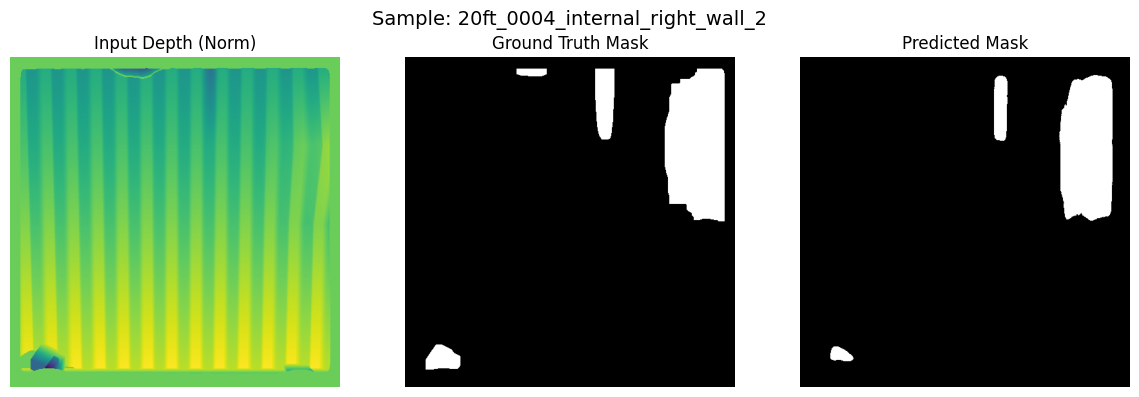

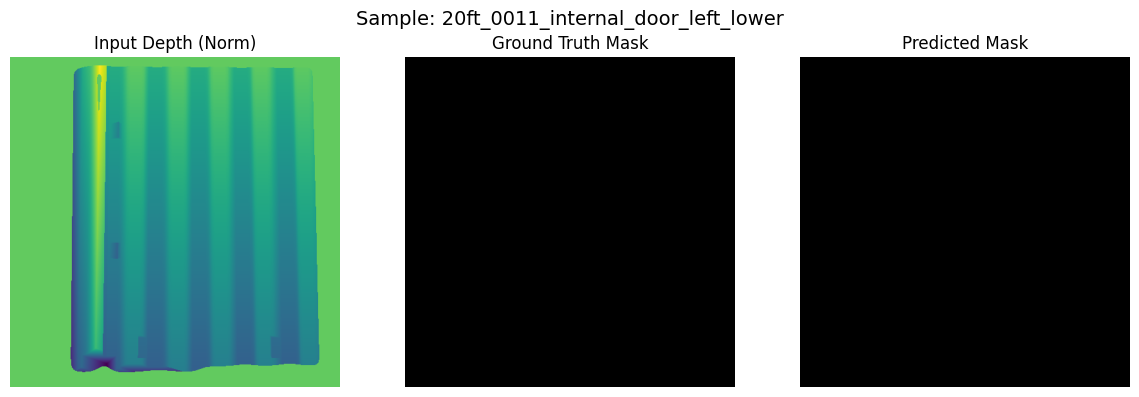

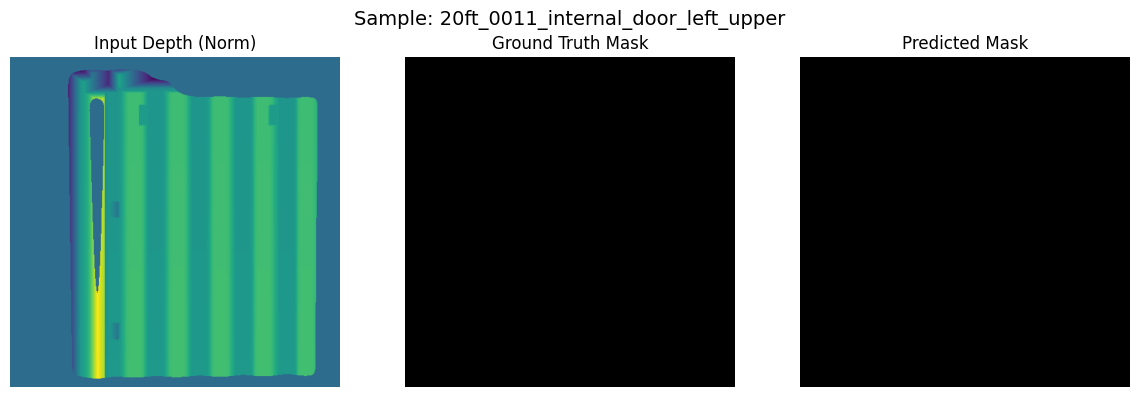

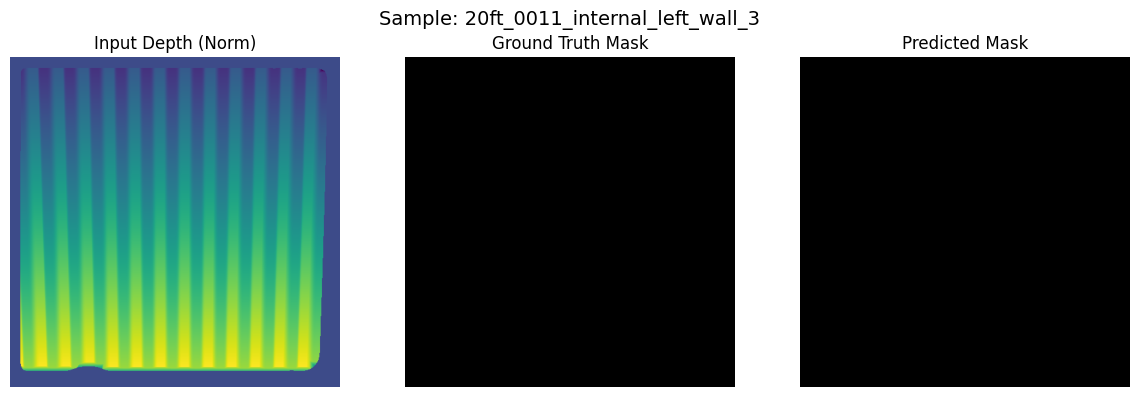

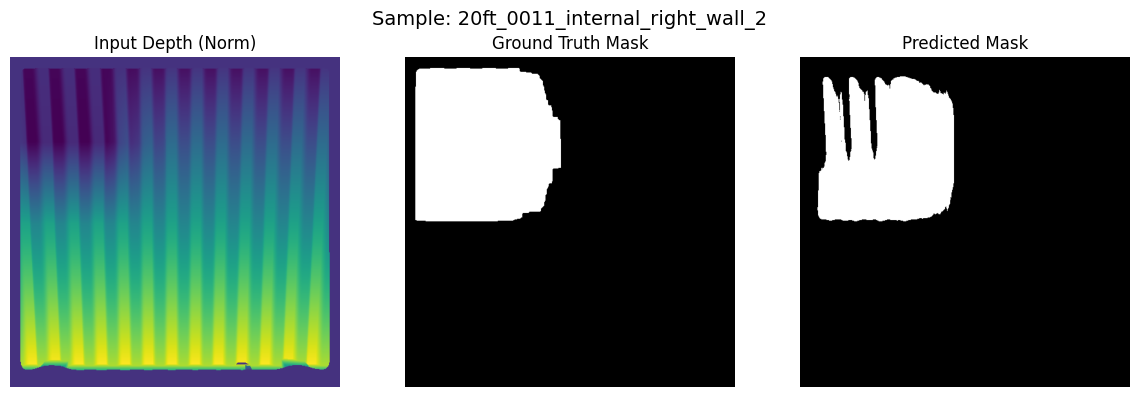

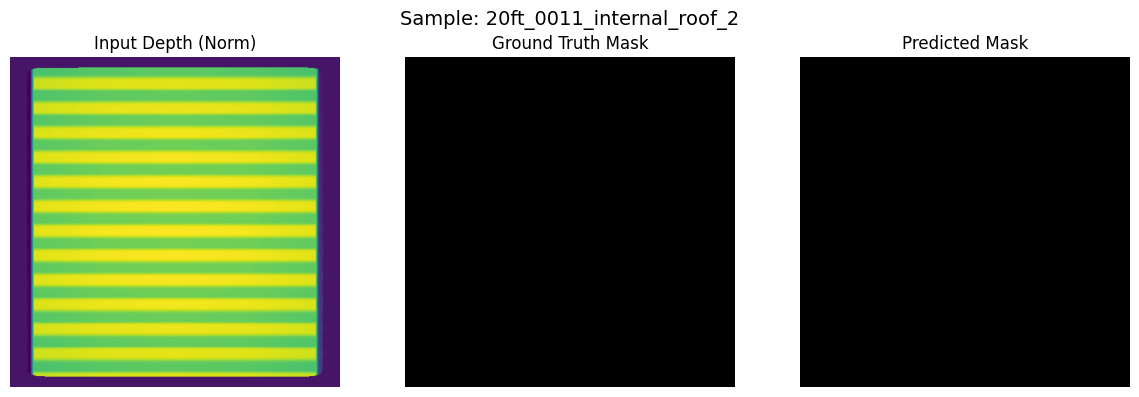

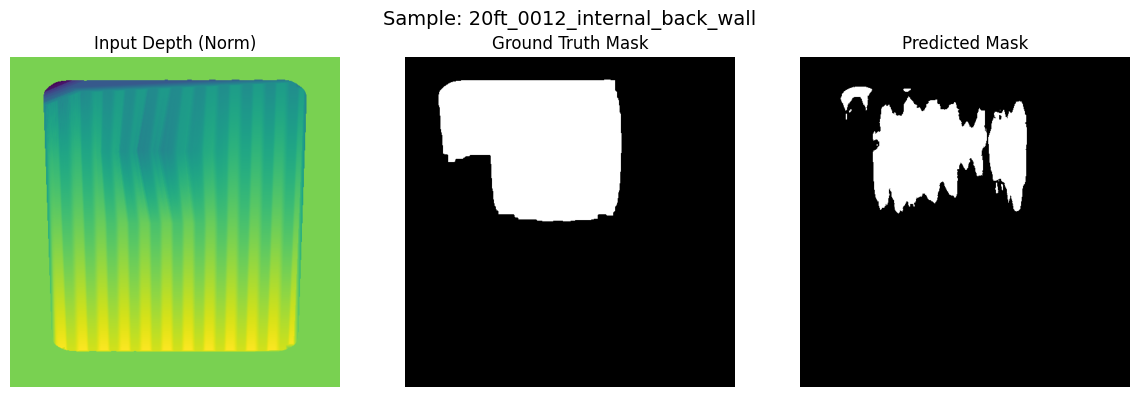

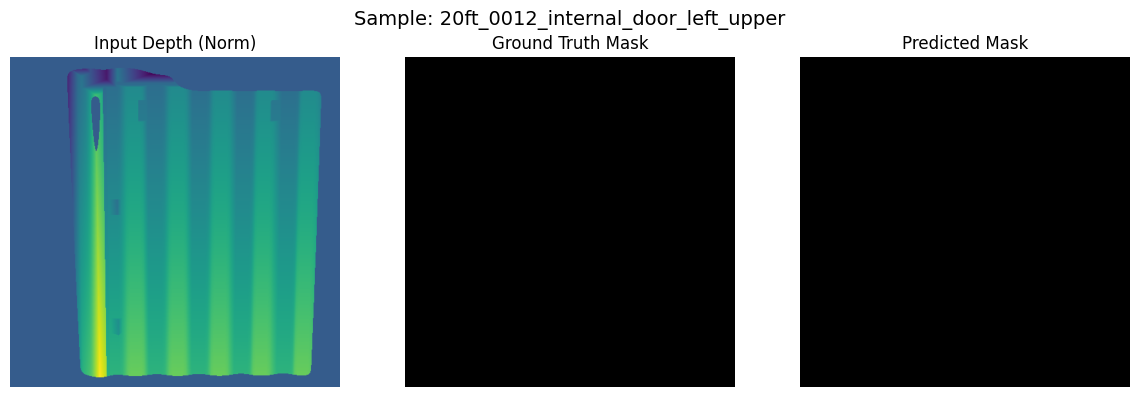

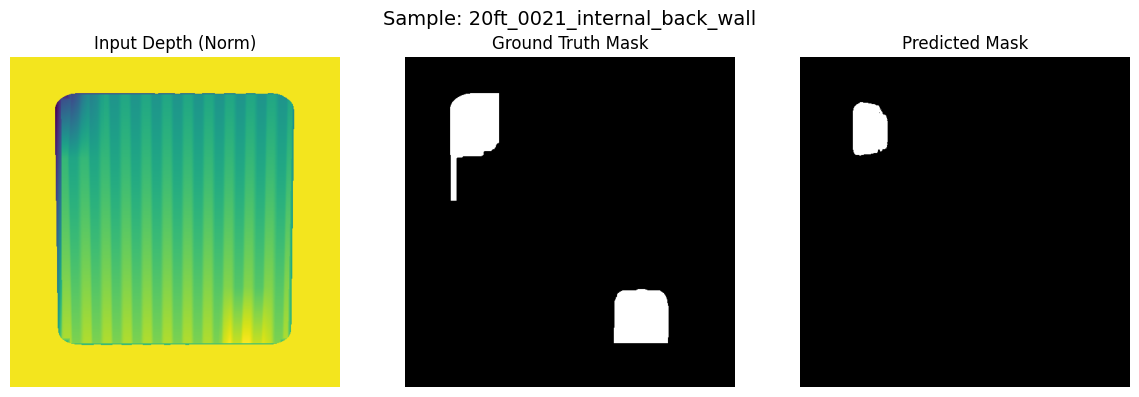

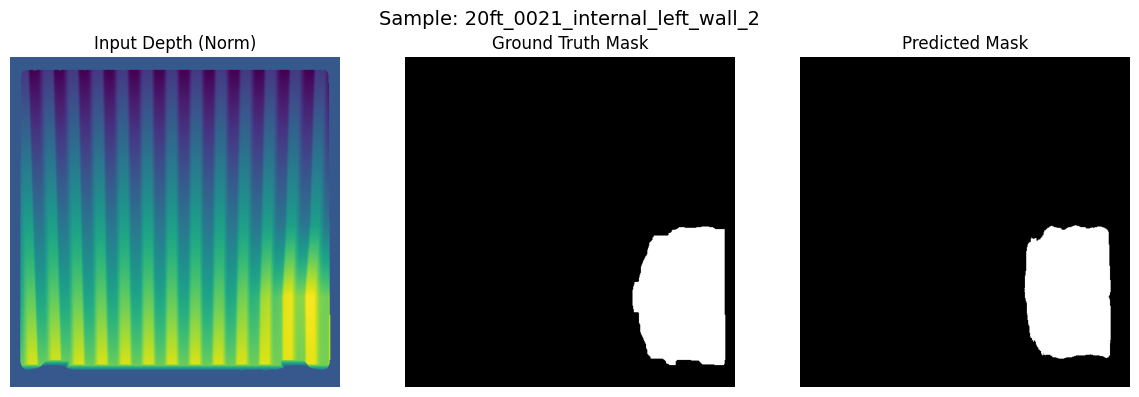

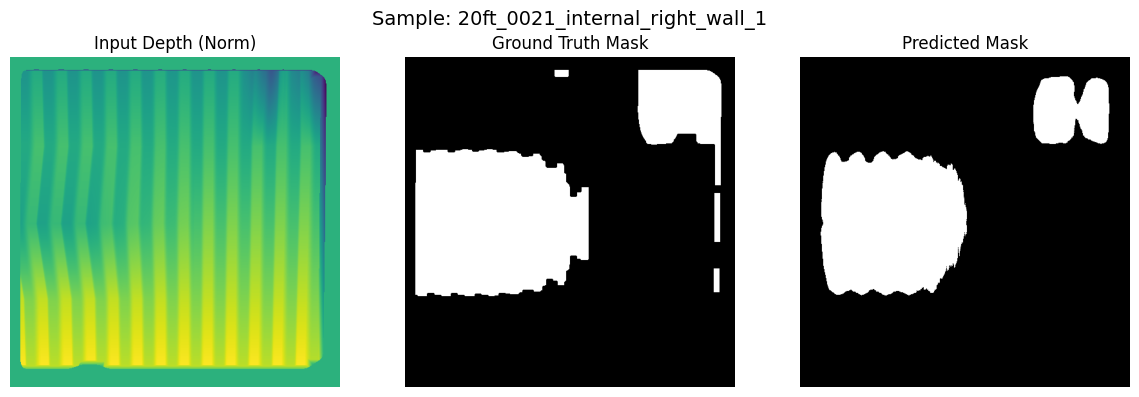

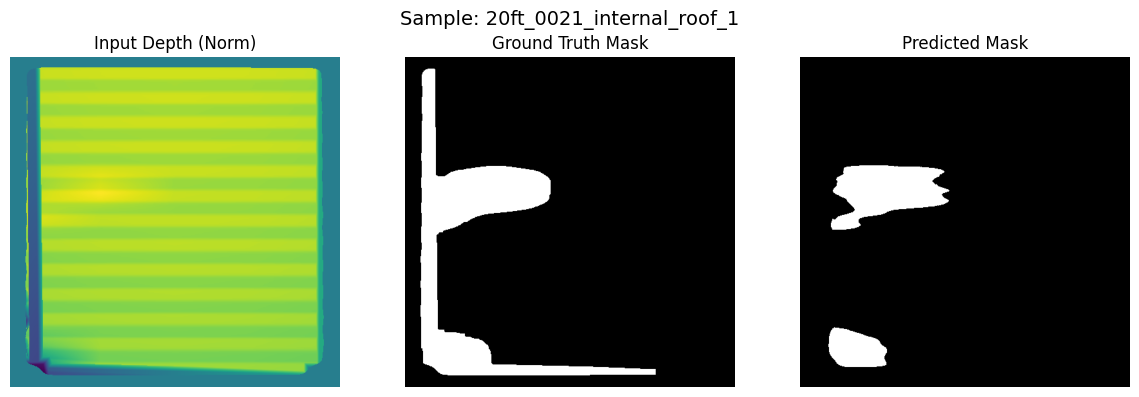

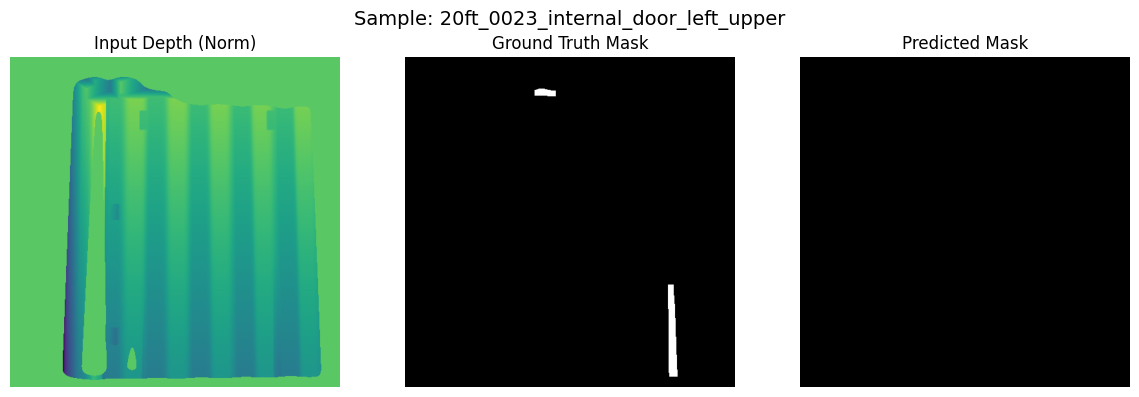

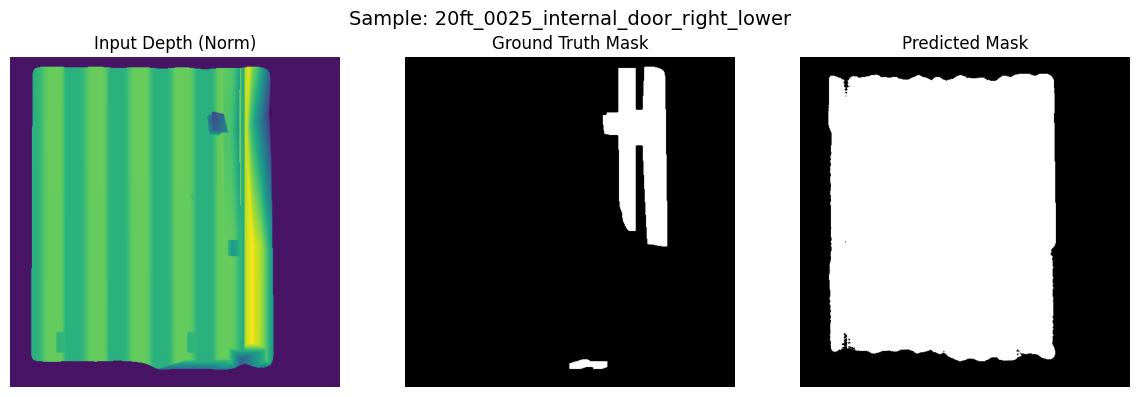

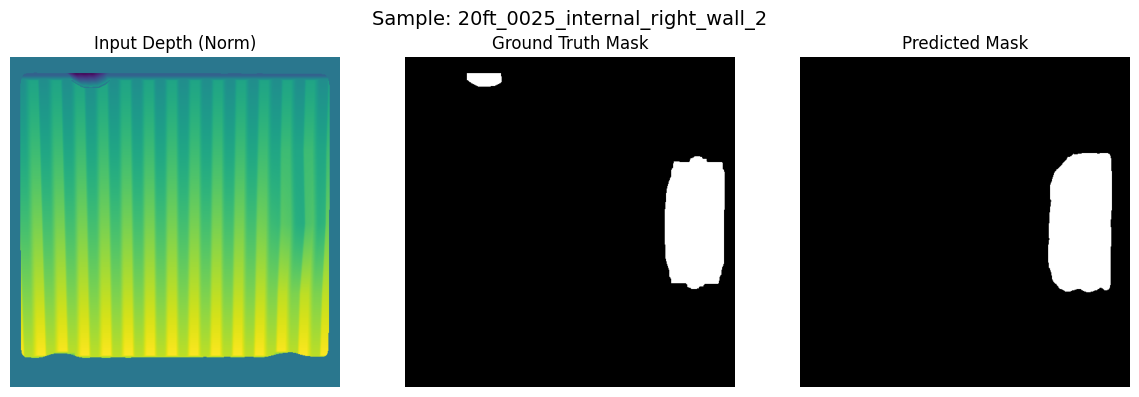

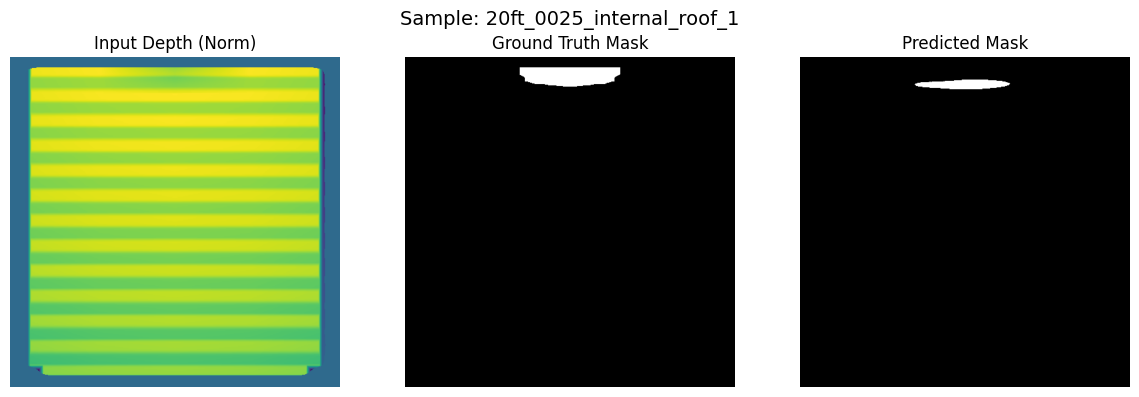

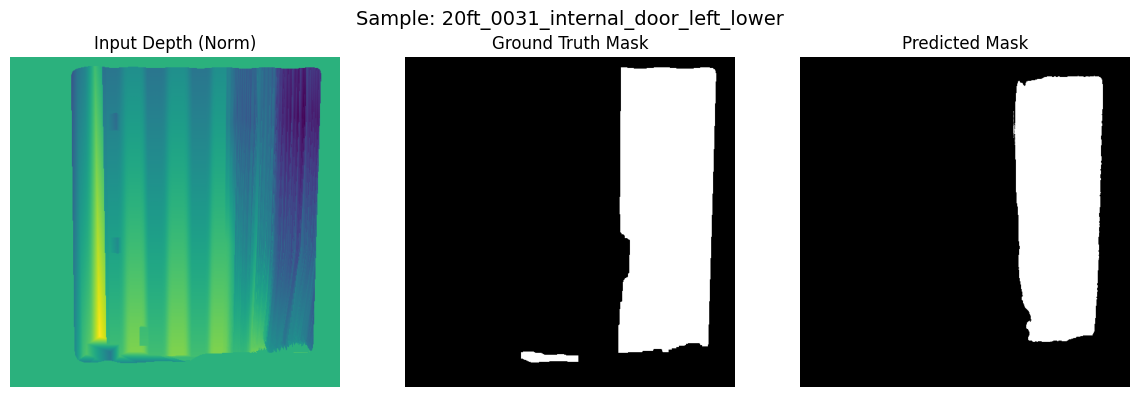

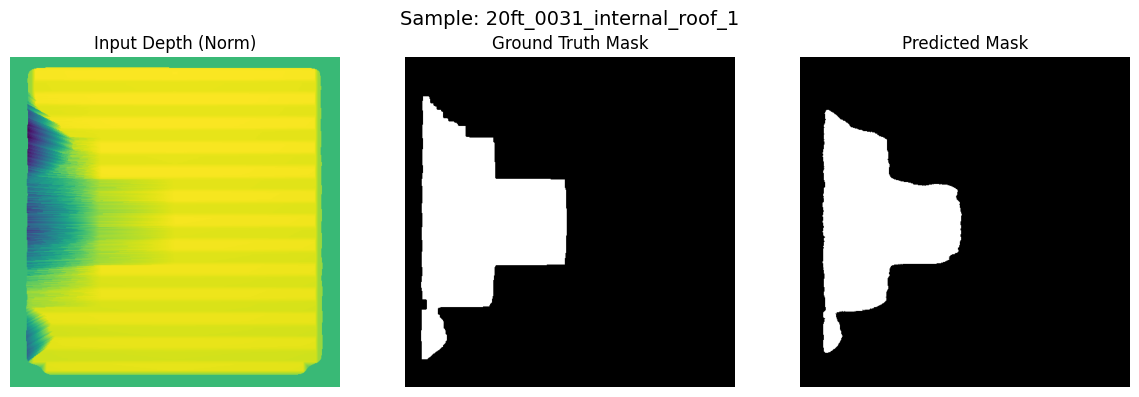

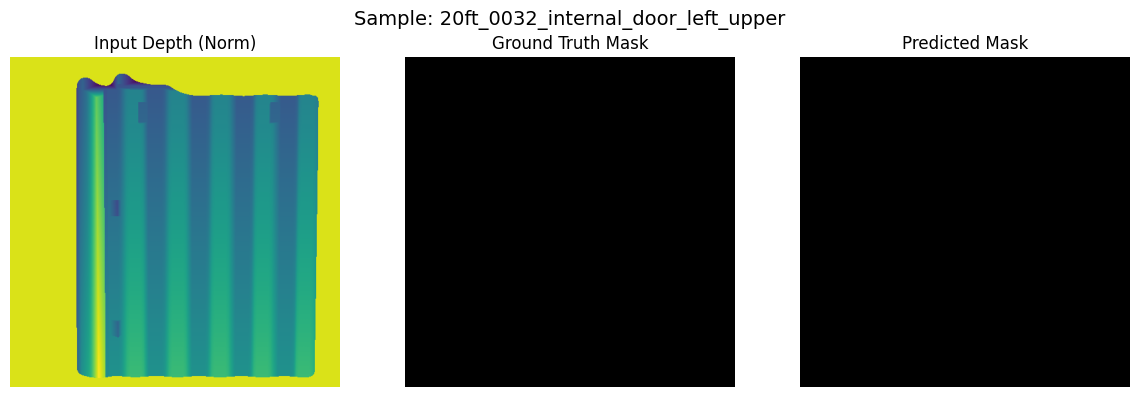

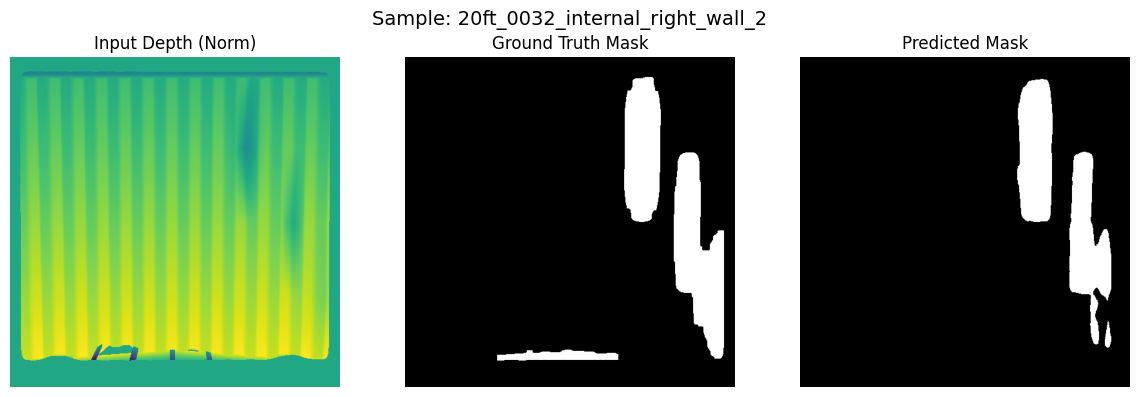

In [ ]:
# ---------------------------
# 10) Visualization of Results
# ---------------------------
import matplotlib.pyplot as plt

# Get the list of prediction images we just saved
pred_files = sorted(glob.glob(os.path.join(pred_out_dir, "*_pred.png")))

# Pick random 3 or take first 3
num_to_show = min(20, len(pred_files))
vis_samples = pred_files[:num_to_show]

if len(vis_samples) == 0:
    print("No predictions found to visualize.")
else:
    for i, pred_path in enumerate(vis_samples):
        # Derive paths based on naming convention in Step 9
        base = os.path.basename(pred_path).replace("_pred.png", "")

        # Load Depth (Visual)
        depth_vis_path = os.path.join(pred_out_dir, base + "_gt_depth.png")
        if os.path.exists(depth_vis_path):
            depth_img = cv2.imread(depth_vis_path, cv2.IMREAD_GRAYSCALE)
        else:
            depth_img = np.zeros((256,256), dtype=np.uint8) # Fallback

        # Load GT Mask
        gt_mask_path = os.path.join(pred_out_dir, base + "_gt_mask.png")
        if os.path.exists(gt_mask_path):
            gt_mask_img = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
        else:
            gt_mask_img = np.zeros_like(depth_img)

        # Load Prediction
        pred_img = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

        # Plot
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"Sample: {base}", fontsize=14)

        plt.subplot(1, 3, 1)
        plt.title("Input Depth (Norm)")
        plt.imshow(depth_img, cmap="viridis")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        plt.imshow(gt_mask_img, cmap="gray")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_img, cmap="gray")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
# ---------------------------
# 9) Batch Inference + Save GT Depth for Comparison
# ---------------------------
# Load the best model weights
if os.path.exists(save_path):
    model.load_state_dict(torch.load(save_path, map_location=device))
    print(f"Loaded model from {save_path}")
model.eval()

# Use ONLY the test set (completely separate from train/val)
# Extract depth file paths from test_pairs
test_files = [pair[0] for pair in test_pairs]  # pair[0] is the depth path
pred_out_dir = os.path.join(OUT_DIR, "batch_preds")
os.makedirs(pred_out_dir, exist_ok=True)

print(f"Processing {len(test_files)} TEST SET files (completely unseen during training)...")

for depth_path in test_files:
    depth = np.load(depth_path).astype(np.float32)

    # ---------------------------
    # Normalize depth (0–1)
    # ---------------------------
    valid = np.isfinite(depth) & (depth > 0)
    if np.any(valid):
        dmin, dmax = float(depth[valid].min()), float(depth[valid].max())
        depth_n = (depth - dmin) / (dmax - dmin + 1e-8)
    else:
        depth_n = np.zeros_like(depth, dtype=np.float32)

    # ---------------------------
    # Gradients + robust norm
    # ---------------------------
    gx = cv2.Sobel(depth, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(depth, cv2.CV_32F, 0, 1, ksize=3)

    def robust_norm(x):
        v = x.flatten()
        v = v[np.isfinite(v)]
        if v.size == 0:
            return np.zeros_like(x, dtype=np.float32)
        med = np.median(v)
        mad = np.median(np.abs(v - med)) + 1e-6
        out = (x - med) / (3.0 * mad)
        out = np.clip(out, -3.0, 3.0)
        out = (out - out.min()) / (out.max() - out.min() + 1e-9)
        return out.astype(np.float32)

    gx_n = robust_norm(gx)
    gy_n = robust_norm(gy)

    # ---------------------------
    # Run model
    # ---------------------------
    inp = np.stack([depth_n, gx_n, gy_n], axis=0)[None, ...]
    inp_t = torch.from_numpy(inp).to(device)

    with torch.no_grad():
        out = model(inp_t)
        out_np = torch.sigmoid(out).cpu().numpy()[0,0]

    pred_mask = (out_np > 0.5).astype(np.uint8) * 255

    # --- FIX IS HERE ---
    # We remove the specific suffix "_dented_depth.npy" so we get just the ID
    base = os.path.basename(depth_path).replace("_dented_depth.npy", "")
    # -------------------

    # ---------------------------
    # Save predicted mask
    # ---------------------------
    save_png = os.path.join(pred_out_dir, base + "_pred.png")
    cv2.imwrite(save_png, pred_mask)

    save_npy = os.path.join(pred_out_dir, base + "_pred.npy")
    np.save(save_npy, (pred_mask > 0).astype(np.uint8))

    # ---------------------------
    # Save *ground truth depth map* (raw)
    # ---------------------------
    gt_depth_npy = os.path.join(pred_out_dir, base + "_gt_depth.npy")
    np.save(gt_depth_npy, depth)

    # ---------------------------
    # Save normalized depth (image preview)
    # ---------------------------
    gt_depth_png = os.path.join(pred_out_dir, base + "_gt_depth.png")
    depth_vis = (depth_n * 255).astype(np.uint8)
    cv2.imwrite(gt_depth_png, depth_vis)

    # ---------------------------
    # Locate and save GT binary mask (if exists)
    # ---------------------------
    # Now this will look for "ID_dent_mask.png" correctly
    gt_mask_path = os.path.join(DATA_DIR, base + "_dent_mask.png")

    # If png not found, check for npy
    real_gt_mask = None
    if os.path.exists(gt_mask_path):
        real_gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE)
    else:
        # Fallback check for .npy mask
        gt_mask_path_npy = os.path.join(DATA_DIR, base + "_dent_mask.npy")
        if os.path.exists(gt_mask_path_npy):
            real_gt_mask = np.load(gt_mask_path_npy)
            real_gt_mask = (real_gt_mask > 0).astype(np.uint8) * 255

    if real_gt_mask is not None:
        save_gt_mask_png = os.path.join(pred_out_dir, base + "_gt_mask.png")
        cv2.imwrite(save_gt_mask_png, real_gt_mask)
        print(f"Saved: {base}")
    else:
        # Create a blank black mask just so the side-by-side doesn't crash later
        real_gt_mask = np.zeros_like(pred_mask)
        print(f"⚠️ GT MASK NOT FOUND FOR: {base}")

    # ---------------------------
    # Optional: Save side-by-side comparison
    # ---------------------------
    # Ensure dimensions match (in case of minor loading discrepancies)
    if real_gt_mask.shape != depth_vis.shape:
        real_gt_mask = cv2.resize(real_gt_mask, (depth_vis.shape[1], depth_vis.shape[0]), interpolation=cv2.INTER_NEAREST)

    side_by_side = np.hstack([
        depth_vis,
        real_gt_mask,
        pred_mask
    ])
    sbs_png = os.path.join(pred_out_dir, base + "_compare.png")
    cv2.imwrite(sbs_png, side_by_side)

print("Batch inference done. Predictions + GT saved to:", pred_out_dir)

Loaded model from /content/drive/MyDrive/AI Y4S1/output_scene_dataset_3/predictions/best_attention_unet.pth
Processing 182 TEST SET files (completely unseen during training)...
Saved: 20ft_0025_internal_door_right_lower
Saved: 40ft_0026_internal_left_wall_1
Saved: 40ft_0005_internal_roof_4
Saved: 20ft_0025_internal_roof_1
Saved: 40ft_hc_0034_internal_roof_6
Saved: 40ft_hc_0024_internal_left_wall_5
Saved: 20ft_0052_internal_left_wall_3
Saved: 20ft_0011_internal_left_wall_3
Saved: 40ft_hc_0008_internal_right_wall_3
Saved: 40ft_hc_0002_internal_roof_4
Saved: 40ft_hc_0017_internal_right_wall_1
Saved: 40ft_0039_internal_door_left_upper
Saved: 20ft_0036_internal_door_left_lower
Saved: 40ft_0037_internal_right_wall_6
Saved: 40ft_hc_0016_internal_roof_5
Saved: 20ft_0021_internal_right_wall_1
Saved: 40ft_0001_internal_door_right_upper
Saved: 20ft_0048_internal_roof_2
Saved: 20ft_0058_internal_left_wall_2
Saved: 40ft_hc_0022_internal_right_wall_2
Saved: 20ft_0032_internal_door_left_upper
Saved: 

In [ ]:

import matplotlib.pyplot as plt

# Visualize first 5 samples
vis_files = test_files[:5]

for depth_path in vis_files:
    base = os.path.basename(depth_path).replace(".npy", "")

    # ---- Load depth ----
    depth = np.load(depth_path).astype(np.float32)

    # ---- Ground Truth path ----
    # expected: *_dented_depth_gt_depth.png
    gt_png = os.path.join(
        pred_out_dir,
        base + "_gt_depth.png"
    )

    if not os.path.exists(gt_png):
        print("GT not found for:", base)
        continue

    gt_mask = cv2.imread(gt_png, cv2.IMREAD_GRAYSCALE)

    # ---- Predicted mask ----
    pred_png = os.path.join(pred_out_dir, base + "_pred.png")
    pred_mask = cv2.imread(pred_png, cv2.IMREAD_GRAYSCALE)

    # ---- Display ----
    plt.figure(figsize=(15, 4))
    plt.suptitle(base, fontsize=14)

    plt.subplot(1, 3, 1)
    plt.title("Depth Map")
    plt.imshow(depth, cmap="viridis")
    plt.colorbar(fraction=0.046)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(gt_mask, cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap="gray")

    plt.tight_layout()
    plt.show()


GT not found for: 20ft_0025_internal_door_right_lower_dented_depth
GT not found for: 40ft_0026_internal_left_wall_1_dented_depth
GT not found for: 40ft_0005_internal_roof_4_dented_depth
GT not found for: 20ft_0025_internal_roof_1_dented_depth
GT not found for: 40ft_hc_0034_internal_roof_6_dented_depth


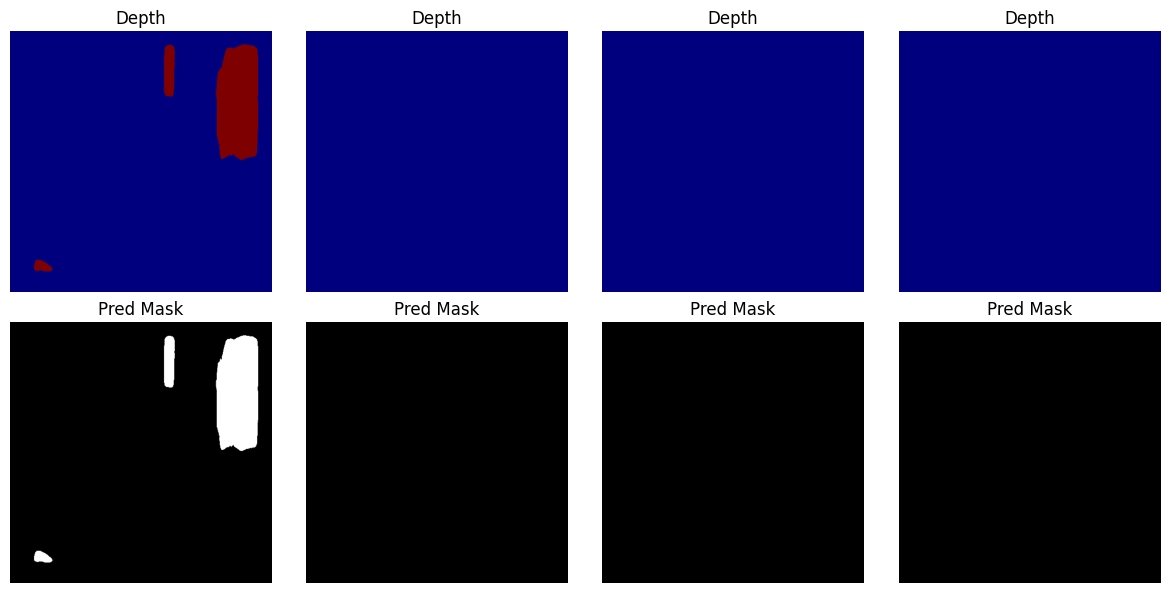

In [ ]:
# ---------------------------
# 10) Quick Visualization of a few results
# ---------------------------
from random import sample
pred_files = sorted(glob.glob(os.path.join(pred_out_dir, "*_pred.png")))
vis_samples = pred_files[:4]
plt.figure(figsize=(12,6))
for i,p in enumerate(vis_samples):
    base = p.replace("_pred.png","")
    depth_path = base + "_pred.npy"
    depth = np.load(depth_path)
    pred = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    plt.subplot(2, len(vis_samples), i+1)
    plt.title("Depth")
    plt.imshow(depth, cmap="jet")
    plt.axis('off')
    plt.subplot(2, len(vis_samples), i+1+len(vis_samples))
    plt.title("Pred Mask")
    plt.imshow(pred, cmap="gray")
    plt.axis('off')
plt.tight_layout()
plt.show()